# Neural Style Transfer in Pytorch
Thanks to Reference: https://nextjournal.com/gkoehler/pytorch-neural-style-transfer <br>
          Paper: https://arxiv.org/abs/1508.06576

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd
os.chdir('gdrive/My Drive/Colab Notebooks/Optimization Methods in Machine Learning')
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content
/content/gdrive/My Drive/Colab Notebooks/Optimization Methods in Machine Learning
'A Neural Algorithm of Artistic Style.pdf'
'AUTOGRAD: AUTOMATIC DIFFERENTIATION.ipynb'
 Homework3.ipynb
'Homework#7_Siner_Ved_Sangyun(siy518,vhp219,sak518).ipynb'
'HW2: Implement Gradient Descent Algorithm.ipynb'
'Implement a Gradient Descent Algorithm using MNIST datasets.ipynb'
'Implement Simple Gradient Descent Algorithm.ipynb'
 Lecture_1.ipynb
 Lecture_2.ipynb
 Lect

## Imports

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Utility Functions

In [0]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')  
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
	
  if shape is not None:
    size = shape
  
  in_transform = transforms.Compose([
    transforms.Resize((size, int(1.5*size))),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  
  image = in_transform(image)[:3, :, :].unsqueeze(0)
  
  return image

In [0]:
style = load_image('./starrynight.jpg')

In [0]:
style.shape

torch.Size([1, 3, 400, 600])

In [0]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array(
    (0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  
  return image

In [0]:
def get_features(image, model, layers=None):
  if layers is None:
    layers = {'0': 'conv1_1','5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2',  ## content layer
              '28': 'conv5_1'}
  features = {}
  x = image
  for name, layer in enumerate(model.features):
    x = layer(x)
    if str(name) in layers:
      features[layers[str(name)]] = x
  
  return features

In [0]:
def gram_matrix(tensor):
  _, n_filters, h, w = tensor.size()
  tensor = tensor.view(n_filters, h * w)
  gram = torch.mm(tensor, tensor.t())
  
  return gram

## Model Setup

In [0]:
torch.utils.model_zoo.load_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth', model_dir='/results/')

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /results/vgg19-dcbb9e9d.pth


OrderedDict([('features.0.weight',
              tensor([[[[-5.3474e-02, -4.9257e-02, -6.7942e-02],
                        [ 1.5314e-02,  4.5068e-02,  2.1444e-03],
                        [ 3.6226e-02,  1.9999e-02,  1.9864e-02]],
              
                       [[ 1.7015e-02,  5.5403e-02, -6.2293e-03],
                        [ 1.4165e-01,  2.2705e-01,  1.3758e-01],
                        [ 1.2000e-01,  2.0030e-01,  9.2114e-02]],
              
                       [[-4.4885e-02,  1.2680e-02, -1.4497e-02],
                        [ 5.9742e-02,  1.3955e-01,  5.4102e-02],
                        [-9.6141e-04,  5.8304e-02, -2.9663e-02]]],
              
              
                      [[[ 2.6072e-01, -3.0489e-01, -5.0152e-01],
                        [ 4.1376e-01, -2.0831e-01, -4.9086e-01],
                        [ 5.8770e-01,  4.2851e-01, -1.3850e-01]],
              
                       [[ 2.8746e-01, -3.3338e-01, -4.5564e-01],
                        [ 3.7836e-01, -2

In [0]:
!ls

'A Neural Algorithm of Artistic Style.pdf'
'AUTOGRAD: AUTOMATIC DIFFERENTIATION.ipynb'
 Homework3.ipynb
'Homework#7_Siner_Ved_Sangyun(siy518,vhp219,sak518).ipynb'
'HW2: Implement Gradient Descent Algorithm.ipynb'
'Implement a Gradient Descent Algorithm using MNIST datasets.ipynb'
'Implement Simple Gradient Descent Algorithm.ipynb'
 Lecture_1.ipynb
 Lecture_2.ipynb
 Lecture_3b.ipynb
 Lecture_3_sgd.ipynb
 Lecture_3_sgd_Martin.ipynb
 Lecture4.ipynb
 OneDrive
 Project#1_Art_Generation_with_Neural_Style_Transfer_NEW.ipynb
 PyTorch_Basic.ipynb
 starrynight.jpg
'Stochastic Gradient Descent.ipynb'
'Stochastic Gradient Descent_MNIST.ipynb'
 Untitled0.ipynb
 vgg19-dcbb9e9d.pth


In [0]:
vgg = models.vgg19()
vgg.load_state_dict(torch.load('./vgg19-dcbb9e9d.pth'))

for param in vgg.parameters():
  param.requires_grad_(False)

#### A Little Trick

In [0]:
for i, layer in enumerate(vgg.features):
  if isinstance(layer, torch.nn.MaxPool2d):
    vgg.features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [0]:
torch.cuda.is_available()

True

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device).eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool

## Loading the Content Image

In [0]:
content = load_image('./shanghai.jpg').to(device)
style = style.to(device)

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
style_grams = {
  layer: gram_matrix(style_features[layer]) for layer in style_features}

In [0]:
target = torch.randn_like(content).requires_grad_(True).to(device)

## A Loss Function of Artistic Style

In [0]:
style_weights = {'conv1_1': 0.75,
                 'conv2_1': 0.5,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

In [0]:
content_weight = 1e4
style_weight = 1e2

## The Style Transfer Loop

In [0]:
optimizer = optim.Adam([target], lr=0.01)

In [0]:
for i in range(1, 401):
  optimizer.zero_grad()
  target_features = get_features(target, vgg)
  
  content_loss = torch.mean((target_features['conv4_2'] -
                             content_features['conv4_2']) ** 2)
  
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean(
      (target_gram - style_gram) ** 2)
    style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
  if i % 50 == 0:
    total_loss_rounded = round(total_loss.item(), 2)
    content_fraction = round(
      content_weight*content_loss.item()/total_loss.item(), 2)
    style_fraction = round(
      style_weight*style_loss.item()/total_loss.item(), 2)
    print('Iteration {}, Total loss: {} - (content: {}, style {})'.format(
      i,total_loss_rounded, content_fraction, style_fraction))
      
final_img = im_convert(target)

Iteration 50, Total loss: 4435.03 - (content: 0.61, style 0.39)
Iteration 100, Total loss: 2159.25 - (content: 0.63, style 0.37)
Iteration 150, Total loss: 1547.77 - (content: 0.62, style 0.38)
Iteration 200, Total loss: 1265.91 - (content: 0.61, style 0.39)
Iteration 250, Total loss: 1088.98 - (content: 0.61, style 0.39)
Iteration 300, Total loss: 966.97 - (content: 0.61, style 0.39)
Iteration 350, Total loss: 877.54 - (content: 0.61, style 0.39)
Iteration 400, Total loss: 829.32 - (content: 0.59, style 0.41)


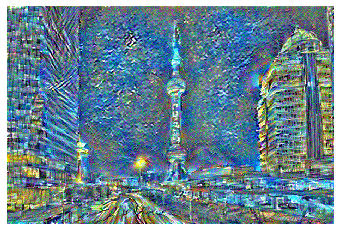

In [0]:
fig = plt.figure()
plt.imshow(final_img)
plt.axis('off')
plt.savefig('/results/modern_starry.png')